# LM-Fit Precession Model Testing with TrES-5 Data

## 🔵 Install Necessary Packages and Libraries

In [1]:
%pip install susie==1.2.2 -q


[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
import sys
sys.path.append("..")
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
from astroquery.ipac.nexsci.nasa_exoplanet_archive import NasaExoplanetArchive

# Importing from src imports directly from source code
from src.susie.timing_data import TimingData
from src.susie.ephemeris import Ephemeris, PrecessionModelEphemeris

import matplotlib.pyplot as plt

from lmfit import Model

## 🔵 Import Data

In [3]:
url = "../example_data/all_lit_times_TrES-5b.csv"
data = pd.read_csv(url)
# tra_or_occs = np.array(data["tra_or_occ"])
epochs = np.array(data["Epoch"].astype('int'))
mid_times = np.array(data["Midtime"])
mid_time_errs = np.array(data["Midtime_err_minus_days"])

### 🔷 Plotting Original Data

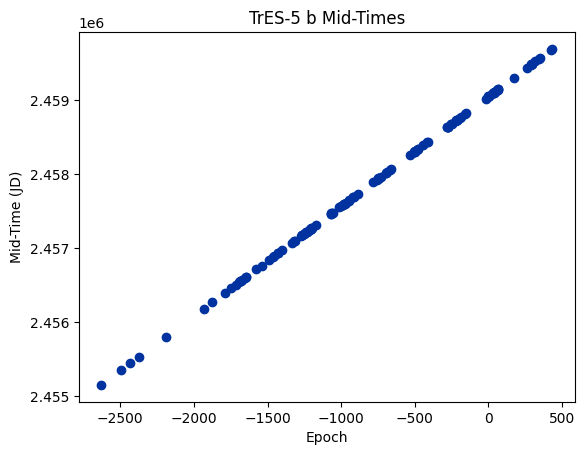

In [4]:
plt.scatter(epochs, mid_times, color="#0033A0")
plt.xlabel("Epoch")
plt.ylabel("Mid-Time (JD)")
plt.title("TrES-5 b Mid-Times")
plt.show()

## 🔵 Helper Functions & Constants

### 🔷 Constants

In [5]:
days_to_seconds = 24*60*60
bsu_blue = "#0033A0"
bsu_orange = "#D64309"
bsu_lightblue = "#00B4ED"
bsu_lightorange = "#F78D1E"

### 🔷 Helper Functions

In [6]:
def calc_anomalistic_period(P, dwdE):
    """Anomalistic Period Calculation (P_a)"""
    return P/(1 - ((1/(2*np.pi))*dwdE))

def calc_pericenter(w0, dwdE, E):
    """Pericenter Calculation (w(E))"""
    return w0 + dwdE*E

def precession_fit(E, T0, P, e, w0, dwdE, tra_or_occ):
    result = np.zeros(len(E))
    for i, t_type in enumerate(tra_or_occ):
        if t_type == 0:
            # transit data
            result[i] = T0 + (E[i]*P) - ((e*calc_anomalistic_period(P, dwdE))/np.pi)*np.cos(calc_pericenter(w0, dwdE, E[i]))
        elif t_type == 1:
            # occultation data
            result[i] = T0 + calc_anomalistic_period(P, dwdE)/2 + (E[i]*P) + ((e*calc_anomalistic_period(P, dwdE))/np.pi)*np.cos(calc_pericenter(w0, dwdE, E[i]))
    return result

def precession_fit_tra_only(E, T0, P, e, w0, dwdE):
    return T0 + (E*P) - ((e*calc_anomalistic_period(P, dwdE))/np.pi)*np.cos(calc_pericenter(w0, dwdE, E))

def precession_fit_occ_only(E, T0, P, e, w0, dwdE):
    return T0 + calc_anomalistic_period(P, dwdE)/2 + (E*P) + ((e*calc_anomalistic_period(P, dwdE))/np.pi)*np.cos(calc_pericenter(w0, dwdE, E))

# def fit_precession_model(epochs, mid_times, mid_time_errs, tra_or_occ):
#     # STARTING VAL OF dwdE CANNOT BE 0, WILL RESULT IN NAN VALUES FOR THE MODEL
#     tra_or_occ_enum = [0 if i == 'tra' else 1 for i in tra_or_occ]
#     model = Model(precession_fit, independent_vars=['E', 'tra_or_occ'])
#     params = model.make_params(T0=0.0, P=1.091423, dwdE=dict(value=0.000984), e=dict(value=0.00310, min=0, max=1), w0=2.62, tra_or_occ=tra_or_occ_enum)
#     result = model.fit(mid_times, params, weights=1.0/mid_time_errs, E=epochs, tra_or_occ=tra_or_occ_enum)
#     return_data = return_precession_dict(result)
#     return(return_data)

def precession_fit_tra_only_set_params_return_result(epochs, mid_times, mid_time_errs, T0, P, e, w0, dwdE):
    model = Model(precession_fit_tra_only, independent_vars=['E'])
    params = model.make_params(T0=dict(value=T0), P=dict(value=P), e=dict(value=e), w0=dict(value=w0), dwdE=dict(value=dwdE))
    result = model.fit(mid_times, params, weights=1.0/mid_time_errs, E=epochs)
    return result

def return_precession_dict(lmfit_result):
    return_data = {
        'period': lmfit_result.params['P'].value,
        'period_err': lmfit_result.params['P'].stderr,
        'conjunction_time': lmfit_result.params['T0'].value,
        'conjunction_time_err': lmfit_result.params['T0'].stderr,
        'eccentricity': lmfit_result.params['e'].value,
        'eccentricity_err': lmfit_result.params['e'].stderr,
        'pericenter': lmfit_result.params['w0'].value,
        'pericenter_err': lmfit_result.params['w0'].stderr,
        'pericenter_change_by_epoch': lmfit_result.params['dwdE'].value,
        'pericenter_change_by_epoch_err': lmfit_result.params['dwdE'].stderr
    }
    return return_data

## 🔵 Create Susie Objects

In [7]:
# Create new transit times object with above data
timing_obj = TimingData('jd', epochs, mid_times, mid_time_uncertainties=mid_time_errs, time_scale='tdb')
ephemeris_obj = Ephemeris(timing_obj)

In [8]:
# MODELS
lin_model = ephemeris_obj.fit_ephemeris("linear")
quad_model = ephemeris_obj.fit_ephemeris("quadratic")
prec_model = ephemeris_obj.fit_ephemeris("precession")

## 🔵 Plotting O-C Plots

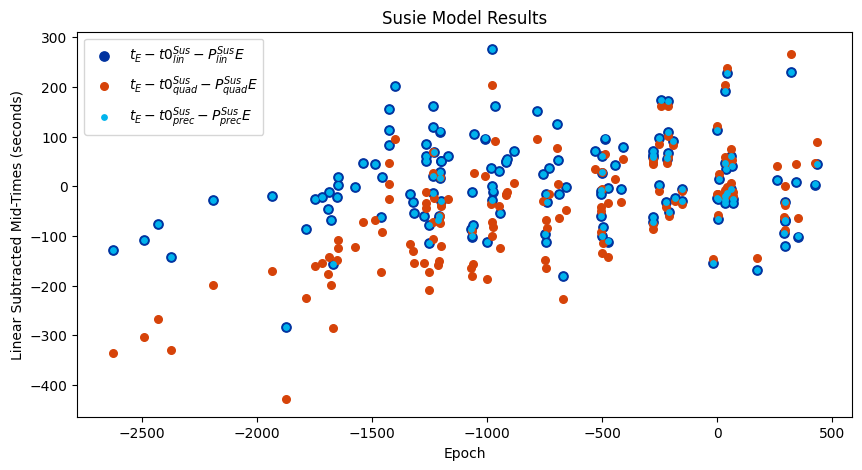

In [9]:
plt.figure(figsize=(10, 5))

plt.scatter(epochs, (mid_times - (lin_model["conjunction_time"] + lin_model["period"]*epochs))*days_to_seconds, color=bsu_blue, label=r"$t_E - t0_{lin}^{Sus} - P_{lin}^{Sus}E$", s=45)
plt.scatter(epochs, (mid_times - (quad_model["conjunction_time"] + quad_model["period"]*epochs))*days_to_seconds, color=bsu_orange, label=r"$t_E - t0_{quad}^{Sus} - P_{quad}^{Sus}E$", s=30)
plt.scatter(epochs, (mid_times - (prec_model["conjunction_time"] + prec_model["period"]*epochs))*days_to_seconds, color=bsu_lightblue, label=r"$t_E - t0_{prec}^{Sus} - P_{prec}^{Sus}E$", s=15)

plt.title("Susie Model Results")
plt.xlabel("Epoch")
plt.ylabel("Linear Subtracted Mid-Times (seconds)")
plt.legend()
plt.show()

## 🔵 LM-Fit Testing

### 🔵 Testing Different LM-Fit Model Parameters

In [10]:
def fit_model_result_return(epochs, mid_times, mid_time_errs):
    model = Model(precession_fit_tra_only, independent_vars=['E'])
    params = model.make_params(T0=dict(value=2e6), P=dict(value=1.48224599), e=dict(value=0.03), w0=dict(value=2.7), dwdE=dict(value=1e-3))
    result = model.fit(mid_times, params, weights=1.0/mid_time_errs, E=epochs)
    return result

In [11]:
prec_model_results = fit_model_result_return(epochs, mid_times, mid_time_errs)
# prec_model_results

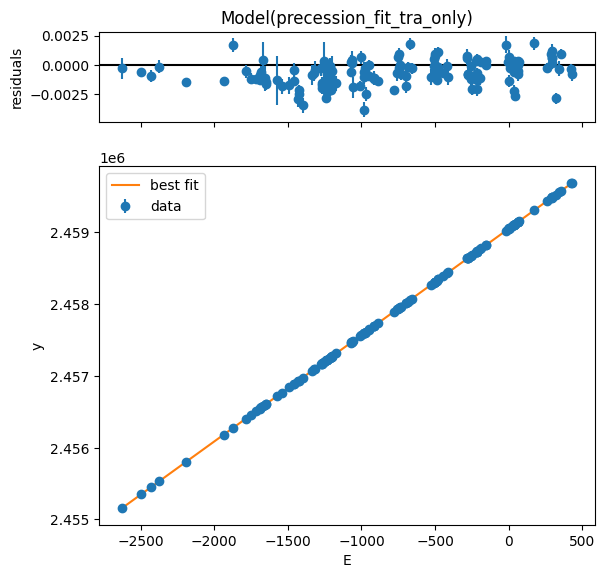

In [12]:
prec_model_results.plot()
plt.show()

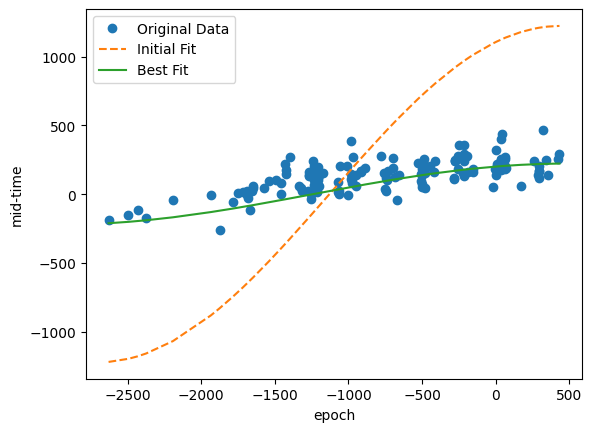

In [13]:
plt.plot(epochs, (mid_times - prec_model_results.params["T0"].value - (prec_model_results.params["P"].value*epochs))*days_to_seconds, "o", label="Original Data")
plt.plot(epochs, (prec_model_results.init_fit - prec_model_results.params["T0"].init_value - (prec_model_results.params["P"].init_value*epochs))*days_to_seconds, "--", label="Initial Fit")
plt.plot(epochs, (prec_model_results.best_fit - prec_model_results.params["T0"].value - (prec_model_results.params["P"].value*epochs))*days_to_seconds, "-", label="Best Fit")
plt.xlabel("epoch")
plt.ylabel("mid-time")
plt.legend()
plt.show()

## 🔵 Testing Initial Values (Results)

**Rank 1: (zero for e)**

| Parameter | Value | | Fit Statistic | Value |
| ----- | ------ |-- |-------------|---------------|
| T0 | 2e6|  |chi-square|	 654.318407|
|P | 1.0 | |reduced chi-square|	 4.74143773|
|e | 0 | |Akaike info crit.|	 227.467173|
|w0 | 2.7 | |Bayesian info crit.|	 242.281396|
|dwdE | 1e-3| |

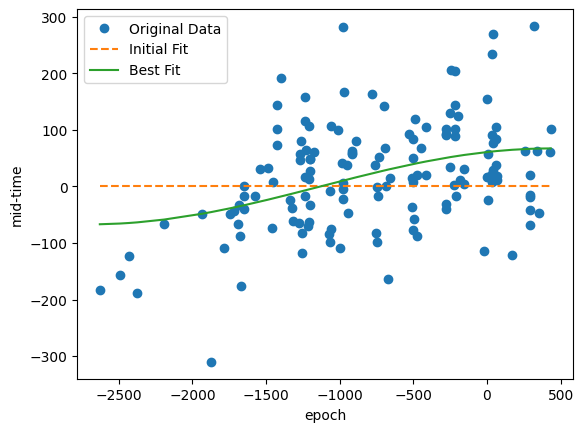

**Rank 2: (zero for e & w0)**

| Parameter | Value | | Fit Statistic | Value |
| ----- | ------ | -- |-------------|---------------|
| T0 | 2e6| | chi-square|	 1044.39101|
|P | 1.0 | |reduced chi-square|	 7.56805079|
|e | 0 | |Akaike info crit.|	 294.333277|
|w0 | 0| |Bayesian info crit.|	 309.147501|
|dwdE | 1e-3|

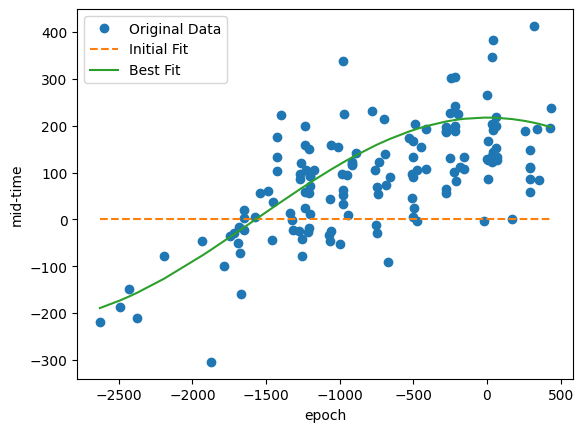

**Rank 3: (values for all, not set in strategic way)**

| Parameter | Value | | Fit Statistic | Value |
| ----- | ------ | -- | -------------|---------------|
| T0 | 2e6|  | chi-square|	 1077.79836|
|P | 1.0 | | reduced chi-square|	 7.81013306|
|e | 0.01 | | Akaike info crit.|	 298.835841|
|w0 | 2.7 | | Bayesian info crit.|	 313.650064|
|dwdE | 1e-3| | 

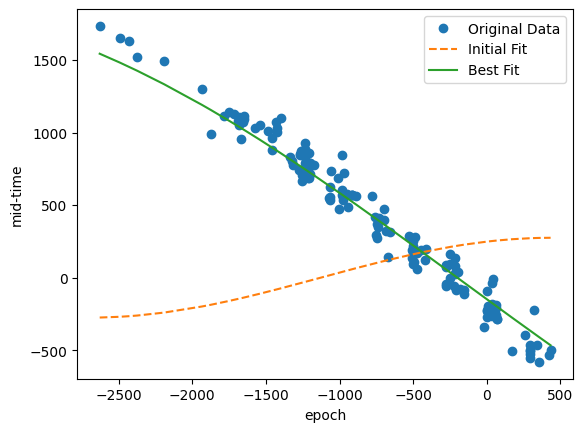

**Rank 4: (zero for w0)**
| Parameter | Value | | Fit Statistic | Value |
| ----- | ------ | -- | -------------|---------------|
| T0 | 2e6|  | chi-square|	 7765.07596|
|P | 1.0 | | reduced chi-square|	 56.2686664|
|e | 0.01 | | Akaike info crit.|	 581.220205|
|w0 | 0 | | Bayesian info crit.|	 596.034428|
|dwdE | 1e-3| | 

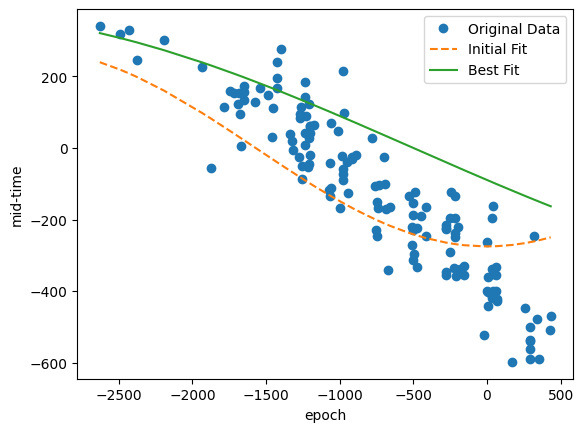

### 🔵 Testing LM-Fit with NASA Exoplanet Archive Pulled Parameters

#### 🔷 Pulling Parameter Values from NASA Exoplanet Archive

We need
 - Conjunction time (pl_tranmid)
 - Orbital period (pl_orbper)
 - Eccentricity (pl_orbeccen)
 - Argument of Periastron (or periapsis) (pl_orblper)
 - Precession rate (not in archive)

In [14]:
def get_precession_starting_parameter_values(object_name):
    # Initiate the values, just in case nothing is found
    data_dict = {
        "pl_tranmid": 2e6,
        "pl_orbper": 1.0,
        "pl_orbeccen": 0.01, 
        "pl_orblper": 2.7
    }
    # Query the archive
    object_data = NasaExoplanetArchive.query_object(object_name, select="pl_tranmid, pl_orbper, pl_orbeccen, pl_orblper")
    # Fill in the value (if it exists)
    for param in data_dict.keys():
        param_data = np.array(object_data[param].value)
        param_data_cleaned = param_data[~np.isnan(param_data)]
        if len(param_data_cleaned) != 0:
            data_dict[param] = param_data_cleaned[0]
    return data_dict

In [15]:
tres_5_b_params = get_precession_starting_parameter_values("TrES-5 b")

#### 🔷 Running Model Fit

In [38]:
nea_data_results = precession_fit_tra_only_set_params_return_result(epochs, mid_times, mid_time_errs, 2e6, tres_5_b_params["pl_orbper"], tres_5_b_params["pl_orbeccen"], tres_5_b_params["pl_orblper"], 1e-3)

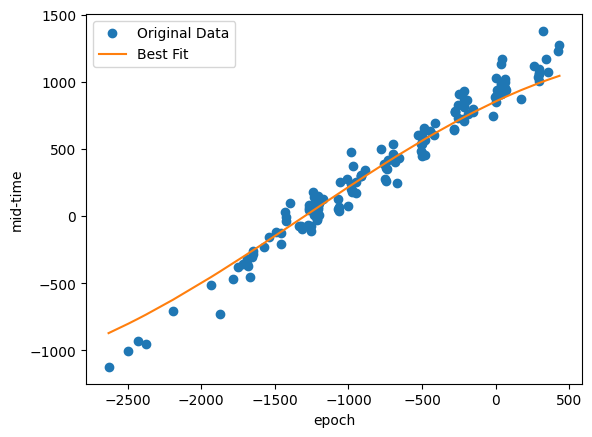

In [39]:
# nea_data_results.plot()
# plt.show()

plt.plot(epochs, (mid_times - nea_data_results.params["T0"].value - (nea_data_results.params["P"].value*epochs))*days_to_seconds, "o", label="Original Data")

# plt.plot(epochs, (nea_data_results.init_fit - nea_data_results.params["T0"].init_value - (nea_data_results.params["P"].init_value*epochs))*days_to_seconds, "--", label="Initial Fit")
plt.plot(epochs, (nea_data_results.best_fit - nea_data_results.params["T0"].value - (nea_data_results.params["P"].value*epochs))*days_to_seconds, "-", label="Best Fit")
plt.xlabel("epoch")
plt.ylabel("mid-time")
plt.legend()
plt.show()

nea_data_results

| | T0 | P |
| -- | -- | -- |
| Lin Model | 2459049.559199508 | 1.4822464326858034 |
| Quad Model | 2459049.5591003583  | 1.4822454821149733 |
| Prec Model (NEA Data) |  2459049.548593805 | 1.4822380198819487 |

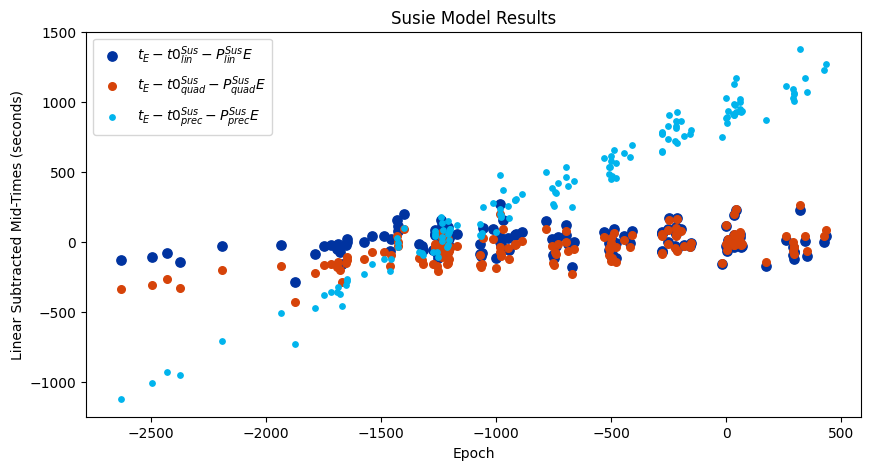

In [40]:
plt.figure(figsize=(10, 5))

plt.scatter(epochs, (mid_times - (lin_model["conjunction_time"] + lin_model["period"]*epochs))*days_to_seconds, color=bsu_blue, label=r"$t_E - t0_{lin}^{Sus} - P_{lin}^{Sus}E$", s=45)
plt.scatter(epochs, (mid_times - (quad_model["conjunction_time"] + quad_model["period"]*epochs))*days_to_seconds, color=bsu_orange, label=r"$t_E - t0_{quad}^{Sus} - P_{quad}^{Sus}E$", s=30)
plt.scatter(epochs, (mid_times - (nea_data_results.params["T0"].value + nea_data_results.params["P"].value*epochs))*days_to_seconds, color=bsu_lightblue, label=r"$t_E - t0_{prec}^{Sus} - P_{prec}^{Sus}E$", s=15)

plt.title("Susie Model Results")
plt.xlabel("Epoch")
plt.ylabel("Linear Subtracted Mid-Times (seconds)")
plt.legend()
plt.show()

### 🔵 Iterative fitting using past model best fit params

Stopped at i=2 with chi squared difference = 0.0


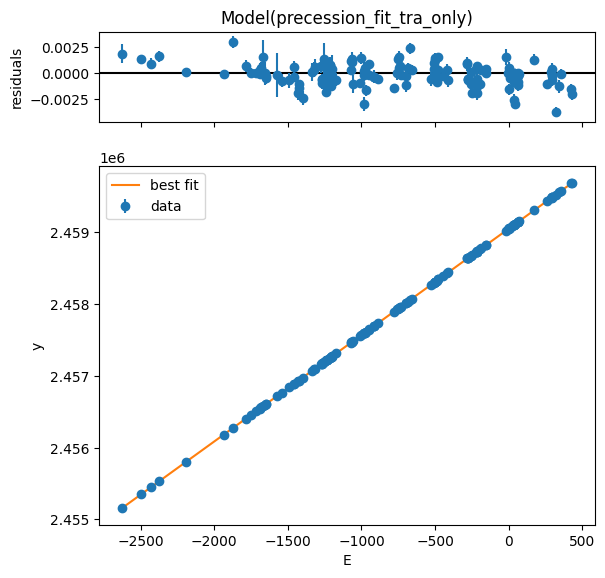

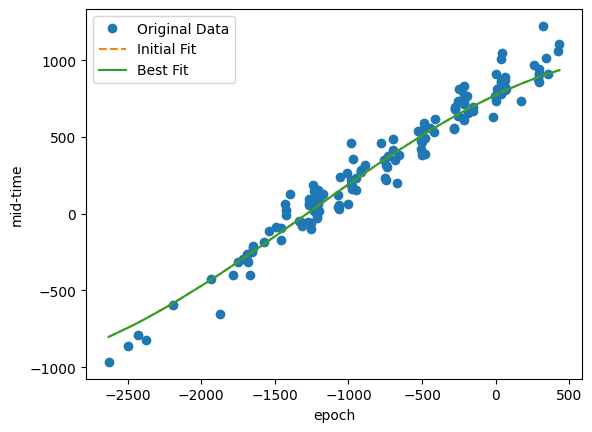

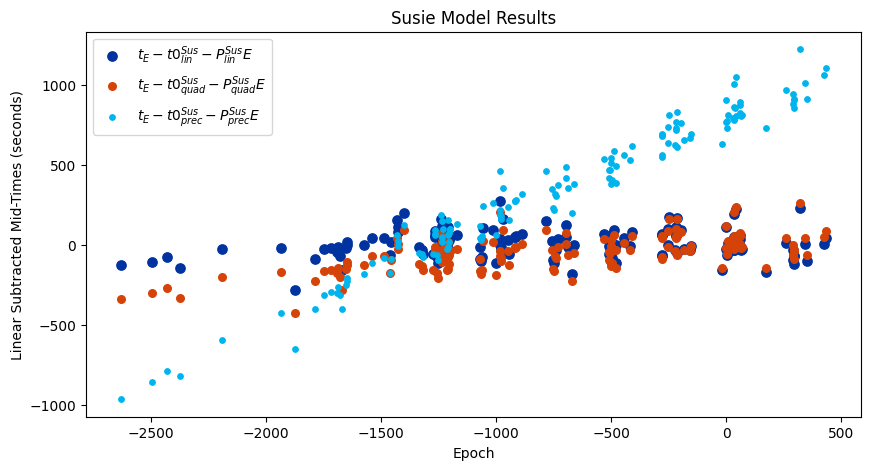

In [48]:
i = 0
chi_squared = np.inf
chi_squared_diff = np.inf
T0, P, e, w0, dwdE = 2457269.3811, 1.4822464, 0.03, 2.7, 1e-3

while i < 100 and chi_squared > 500 and chi_squared_diff > 0.01:
    model_results = precession_fit_tra_only_set_params_return_result(epochs, mid_times, mid_time_errs, T0, P, e, w0, dwdE)
    chi_squared_diff = abs(chi_squared - model_results.chisqr)
    chi_squared = model_results.chisqr
    T0 = model_results.params["T0"].value
    P = model_results.params["P"].value
    e = model_results.params["e"].value
    w0 = model_results.params["w0"].value
    dwdE = model_results.params["dwdE"].value
    i += 1

print(f"Stopped at i={i} with chi squared difference = {chi_squared_diff}")

model_results.plot()
plt.show()

plt.plot(epochs, (mid_times - model_results.params["T0"].value - (model_results.params["P"].value*epochs))*days_to_seconds, "o", label="Original Data")
plt.plot(epochs, (model_results.init_fit - model_results.params["T0"].init_value - (model_results.params["P"].init_value*epochs))*days_to_seconds, "--", label="Initial Fit")
plt.plot(epochs, (model_results.best_fit - model_results.params["T0"].value - (model_results.params["P"].value*epochs))*days_to_seconds, "-", label="Best Fit")
plt.xlabel("epoch")
plt.ylabel("mid-time")
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))

plt.scatter(epochs, (mid_times - (lin_model["conjunction_time"] + lin_model["period"]*epochs))*days_to_seconds, color=bsu_blue, label=r"$t_E - t0_{lin}^{Sus} - P_{lin}^{Sus}E$", s=45)
plt.scatter(epochs, (mid_times - (quad_model["conjunction_time"] + quad_model["period"]*epochs))*days_to_seconds, color=bsu_orange, label=r"$t_E - t0_{quad}^{Sus} - P_{quad}^{Sus}E$", s=30)
plt.scatter(epochs, (mid_times - (model_results.params["T0"].value + model_results.params["P"].value*epochs))*days_to_seconds, color=bsu_lightblue, label=r"$t_E - t0_{prec}^{Sus} - P_{prec}^{Sus}E$", s=15)

plt.title("Susie Model Results")
plt.xlabel("Epoch")
plt.ylabel("Linear Subtracted Mid-Times (seconds)")
plt.legend()
plt.show()

model_results

### 🔵 Testing with Removing Linear Portion and Just Fitting to Non-Lin Portion

In [ ]:
def precession_fit_tra_only_set_params_return_result(epochs, mid_times, mid_time_errs, T0, P, e, w0, dwdE):
    model = Model(precession_fit_tra_only, independent_vars=['E'])
    params = model.make_params(T0=dict(value=T0), P=dict(value=P), e=dict(value=e), w0=dict(value=w0), dwdE=dict(value=dwdE))
    result = model.fit(mid_times, params, weights=1.0/mid_time_errs, E=epochs)
    return result

In [54]:
lin_subtracted_mid_times = mid_times - lin_model["conjunction_time"] - lin_model["period"]*epochs

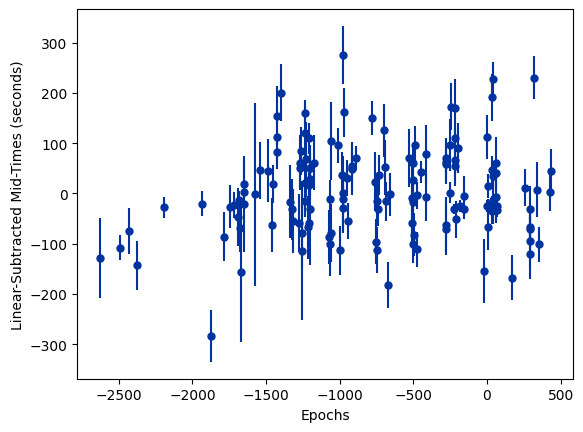

In [68]:
plt.errorbar(epochs, lin_subtracted_mid_times*days_to_seconds, yerr=mid_time_errs*days_to_seconds, color=bsu_blue, marker=".", markersize=10, ls="")
plt.xlabel("Epochs")
plt.ylabel("Linear-Subtracted Mid-Times (seconds)")
plt.show()

In [194]:
def precession_fit_tra_only_lin_only(E, P, e, w0, dwdE):
    return -((e*calc_anomalistic_period(P, dwdE))/np.pi)*np.cos(calc_pericenter(w0, dwdE, E))

def precession_fit_tra_only_lin_only_set_params_return_result(epochs, mid_times, mid_time_errs, P, e, w0, dwdE):
    model = Model(precession_fit_tra_only_lin_only, independent_vars=['E'])
    params = model.make_params(P=dict(value=P), e=dict(value=e), w0=dict(value=w0), dwdE=dict(value=dwdE))
    result = model.fit(mid_times, params, weights=1.0/mid_time_errs, E=epochs)
    return result

In [196]:
lin_subtracted_results = precession_fit_tra_only_lin_only_set_params_return_result(epochs, lin_subtracted_mid_times, mid_time_errs, 0.01, 0, 2.0, 1e-4)
lin_subtracted_results

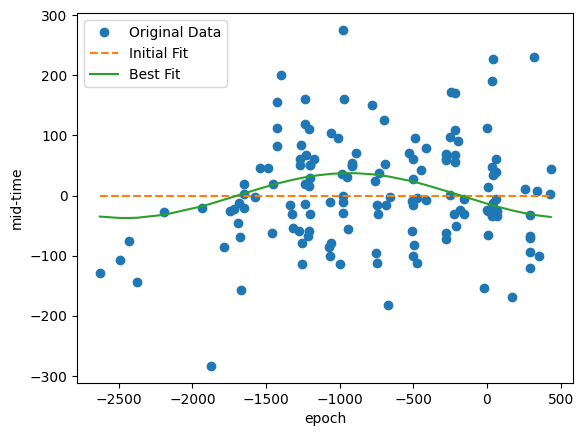

In [197]:
plt.plot(epochs, lin_subtracted_mid_times*days_to_seconds, "o", label="Original Data")
# plt.plot(epochs, (lin_subtracted_results.init_fit - lin_subtracted_results.params["T0"].init_value - (lin_subtracted_results.params["P"].init_value*epochs))*days_to_seconds, "--", label="Initial Fit")
plt.plot(epochs, lin_subtracted_results.init_fit*days_to_seconds, "--", label="Initial Fit")
plt.plot(epochs, lin_subtracted_results.best_fit*days_to_seconds, "-", label="Best Fit")
plt.xlabel("epoch")
plt.ylabel("mid-time")
plt.legend()
plt.show()